# Figure 3

FALTA ESTO!!!!

In [152]:
import sys
sys.path.append("../src")

import warnings
warnings.filterwarnings("ignore")

import re
import PIL
import math
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

from pathlib import Path
from scipy.stats import pearsonr
from collections import defaultdict
from statsmodels.formula.api import ols
from statsmodels.stats.proportion import proportions_ztest

from Config.config import PATHS
from Utils.indices import AlternationIndex
from Utils.utils import GetMeasurements, Grid
from Utils.bar_utils import BarRenderer

### Load AICs

In [ ]:
file_all = PATHS['parameter_fit_results'] / Path('best_fit_all.json')
df_all = pd.read_json(file_all, lines=True)
df_all.sort_values(by=['AIC', 'model_name'], inplace=True)
df_parameters = df_all[['model_name', 'free_parameters']]
df_all.drop(columns=['free_parameters', 'fixed_parameters'], inplace=True)
df_all['deviance'] = df_all['deviance'].apply(lambda x: int(-x))
df_all['AIC'] = df_all['AIC'].apply(lambda x: int(x))
df_all['AIC_diff'] = df_all['AIC'] - df_all['AIC'].min()
df_all = df_all[['model_name', 'deviance', 'AIC', 'AIC_diff']].reset_index(drop=['index'])

df_all

,model_name,deviance,AIC,AIC_diff
0,FRA+Payoff+Attendance,18804,37620,0
1,Attendance-M2,18979,37965,345
2,Attendance-M3,19641,39288,1668
3,Attendance-M1,19915,39837,2217
4,MFP-M2,20613,41231,3611
5,MFP-M3,20704,41412,3792
6,AvailableSpace-M3,20765,41537,3917
7,AvailableSpace-M2,20800,41606,3986
8,FRA,21021,42049,4429
9,Fairness-M2,21043,42092,4472


### Distances between models

In [ ]:
# ----- Inputs -----
# models = ['Random', 'WSLS-M1', 'WSLS-M2', 'WSLS-M3', 'Payoff-M1',
#           'Payoff-M2', 'Payoff-M3', 'Attendance-M1', 'Attendance-M2',
#           'Attendance-M3', 'AvailableSpace-M1', 'AvailableSpace-M2',
#           'AvailableSpace-M3', 'Fairness-M1', 'Fairness-M2', 'Fairness-M3',
#           'MFP-M1', 'MFP-M2', 'MFP-M3', 'FRA', 'FRA+Payoff+Attendance']

models = df_all['model_name'].values

mechanisms = ['Stochastic', 'Heuristic', 'Best-response', 'Error-correction', 'Schemata']
m2i = {
    'Stochastic': 0,
    'Heuristic': 1,
    'Best-response': 3,
    'Error-correction': 4,
    'Schemata': 5
}

# For each *base* model, list which high-level mechanisms it belongs to (by index).
dict_mechanisms = {
    'FRA+Payoff+Attendance': [4, 5],   # Error-correction + Schemata
    'FRA': [5],                        # Schemata
    'Attendance': [4],                 # Error-correction
    'Payoff': [4],                     # Error-correction
    'Fairness': [4],                   # Error-correction
    'AvailableSpace': [4],             # Error-correction
    'MFP': [3],                        # Best-response
    'WSLS': [1],                       # Heuristic
    'Random': [0]                      # Stochastic
}

In [ ]:
# ----- Helpers -----
level_pattern = re.compile(r'-M(\d+)$')

def parse_base_and_level(model_name: str):
    """Return (base_name, level:int). If no level in the name, level=0."""
    m = level_pattern.search(model_name)
    if m:
        level = int(m.group(1))
        base = model_name[:m.start()]  # everything before '-M#'
    else:
        base = model_name
        level = 0
    return base, level

def base_for_model(model_name: str):
    """Return base_name"""
    m = level_pattern.search(model_name)
    if m:
        base = model_name[:m.start()]  # everything before '-M#'
    else:
        base = model_name
    return base

def mechanisms_for_model(model_name: str):
    """Return a set of mechanism indices for the given model name."""
    base, _ = parse_base_and_level(model_name)
    mech_list = dict_mechanisms.get(base, [])
    return set(mech_list)

def level_for_model(model_name: str):
    """Numeric level (ordinal). Models without -M# are treated as level 0."""
    base, lvl = parse_base_and_level(model_name)
    if base == 'Random':
        lvl = 1
    elif 'FRA' in base:
        lvl = 4
    return lvl

def model_distance(a: str, b: str):
    """Distance = 1/(#shared_mechanisms) + |level_a - level_b|; ∞ if none shared."""
    ma = mechanisms_for_model(a)
    mb = mechanisms_for_model(b)
    shared = len(ma & mb)
    if base_for_model(a) == base_for_model(b):
        m_distance = 0
    elif shared == 0:
        m_distance = 2
    else:
        m_distance = 1.0 / shared
    return m_distance

In [ ]:
# ----- Mechanism-only distance (ignore levels here) -----
# distance = 1 / (#shared_mechanisms); ∞ if none shared
n = len(models)
D_mech = np.zeros((n, n), dtype=float)
for i in range(n):
    for j in range(n):
        if i == j:
            D_mech[i, j] = 0.0
            continue
        mi = mechanisms_for_model(models[i])
        mj = mechanisms_for_model(models[j])
        shared = len(mi & mj)
        if base_for_model(models[i]) == base_for_model(models[j]):
            m_distance = 0
        elif shared == 0:
            m_distance = 2
        else:
            m_distance = 1.0 / shared
        D_mech[i, j] = m_distance

dist_df = pd.DataFrame(D_mech, index=models, columns=models)

In [ ]:
# ----- 1D embedding for mechanisms -----
mds1 = MDS(
    n_components=1,
    dissimilarity='precomputed',
    random_state=5,
    n_init=8,
    max_iter=1000,
    normalized_stress='auto'
)
mech_1d = mds1.fit_transform(D_mech).ravel()

# Optionally mean-center for nicer plotting
mech_1d = mech_1d - mech_1d.mean()

In [ ]:
emb_df

,model,mechanism_axis,level,AIC,AIC_diff,level_jittered
0,FRA+Payoff+Attendance,-2.380952e-01,3.0,37620,0,3.222001
1,Attendance-M2,-6.344132e-17,2.0,37965,345,2.223176
2,Attendance-M3,1.057355e-17,3.0,39288,1668,3.106130
3,Attendance-M1,-6.344132e-17,1.0,39837,2217,1.014321
4,MFP-M2,-1.714286e+00,2.0,41231,3611,1.921572
5,MFP-M3,-1.714286e+00,3.0,41412,3792,3.053348
6,AvailableSpace-M3,4.761905e-01,3.0,41537,3917,3.063389
7,AvailableSpace-M2,4.761905e-01,2.0,41606,3986,1.918110
8,FRA,-1.476190e+00,3.0,42049,4429,2.919503
9,Fairness-M2,-3.809524e-01,2.0,42092,4472,2.299670


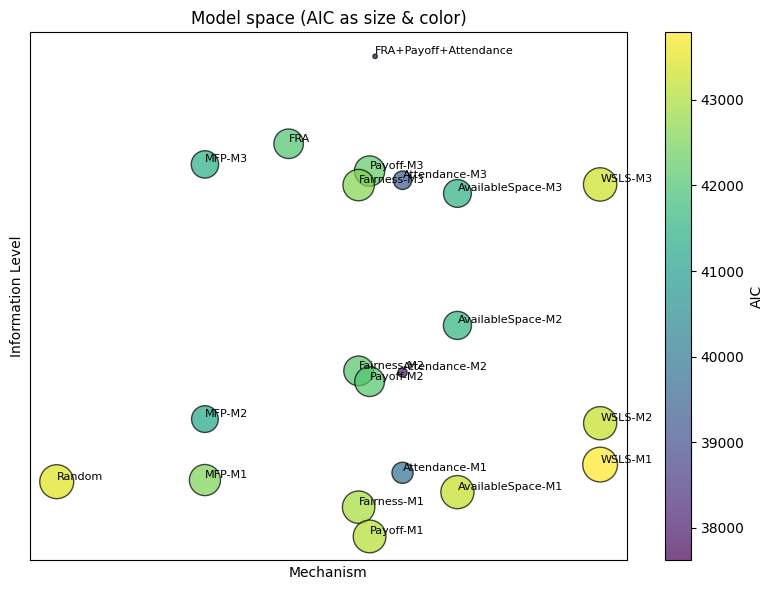

In [ ]:
# ----- Build 2D embedding: (mechanism_axis, level_axis) -----
levels = np.array([level_for_model(m) for m in models], dtype=float)

emb_df = pd.DataFrame({
    'model': models,
    'mechanism_axis': mech_1d,  # learned 1D mechanism embedding
    'level': levels,             # explicit ordinal level axis
    'AIC': df_all['AIC'].values,
    'AIC_diff': df_all['AIC_diff'].values
})

# Fix strange mistake
emb_df.loc[12, 'mechanism_axis'] = emb_df.loc[4, 'mechanism_axis']
emb_df.loc[14, 'mechanism_axis'] = emb_df.loc[9, 'mechanism_axis']
emb_df.loc[11, 'mechanism_axis'] = emb_df.loc[10, 'mechanism_axis']
emb_df.loc[15, 'mechanism_axis'] = emb_df.loc[10, 'mechanism_axis']
emb_df.loc[8, 'mechanism_axis'] = emb_df.loc[0, 'mechanism_axis'] - 0.75
emb_df.loc[19, 'mechanism_axis'] = -3

# ----- Quick plot -----
# add vertical jitter
rng = np.random.default_rng(42)  # for reproducibility
jitter = rng.uniform(0, 1, size=len(emb_df))  # small noise around 0
emb_df['level_jittered'] = emb_df['level'] + jitter

# Normalize AIC for sizes
size_scale = 1 / emb_df['AIC_diff'].max()  # relative scaling
sizes = 10 + emb_df['AIC_diff'] * 0.1

# Scatter plot with color and size by AIC
plt.figure(figsize=(8, 6))
sc = plt.scatter(
    emb_df['mechanism_axis'], emb_df['level_jittered'],
    c=emb_df['AIC'], s=sizes, cmap='viridis', alpha=0.7, edgecolor='k'
)

# Labels for each point
for _, row in emb_df.iterrows():
    plt.text(row['mechanism_axis'], row['level_jittered'],
             row['model'], fontsize=8, ha='left', va='bottom')

# Colorbar
cbar = plt.colorbar(sc)
cbar.set_label('AIC')

# Axes labels and title
plt.xlabel('Mechanism')
plt.xticks(ticks=[])
plt.ylabel('Information Level')
plt.yticks(ticks=[])
plt.title('Model space (AIC as size & color)')
plt.tight_layout()
plt.show()

### Loading and preprocessing data

In [153]:
# Load human data
file_name = 'all_data.csv'
file = PATHS['human_data'] / Path(file_name)
print(f'Loading data from {file}...')
data = pd.read_csv(file)
data['source'] = 'humans'
data['model'] = data.apply(lambda row: f"{row['room']}-{row['num_players']}-{row['threshold']:.2f}", axis=1)
data['num_players'] = data['num_players'].astype(int)
data['round'] = data['round'].astype(int)
data['decision'] = data['decision'].astype(int)
data['group'] = data['group'].apply(lambda x: x.split('-')[0] if 'Grupo' not in x else x.split('-')[1])

# data = data[data['threshold'] != 1]
data.drop(columns=['room', 'date', 'timeup', 'time', 'attendance', 'ac_score', 'choice'], inplace=True)

# Change round to round within session
dict_num_sessions = {}
for key, grp in data.groupby('group'):
    num_players = grp['num_players'].unique()[0]
    num_sessions = grp['threshold'].unique().size
    x = dict_num_sessions.get(num_players, None)
    if x != None and num_sessions != x:
        raise Exception('Inconsistent number of sessions per number of players')
    dict_num_sessions[num_players] = num_sessions

group_counter = {grp:0 for grp in data['group'].unique()}
rounds_counter = dict() 
dict_sessions_downwards = defaultdict()
dict_sessions_upwards = defaultdict()
data.sort_values(by=['group', 'treatment', 'threshold'], inplace=True)
for (group, treatment, threshold, num_players), grp in data.groupby(['group', 'treatment', 'threshold', 'num_players']):
    rounds_counter[(group, threshold)] = [grp['round'].min(), grp['round'].max()]
    num_thresholds = dict_num_sessions[num_players]
    if treatment == 'downwards':
        count = num_thresholds - group_counter[group]
        group_counter[group] += 1
        dict_sessions_downwards[(group, threshold)] = count
    elif treatment == 'upwards':
        group_counter[group] += 1
        count = group_counter[group]
        dict_sessions_upwards[(group, threshold)] = count
    else:
        dict_sessions_downwards[(group, threshold)] = 1

dict_sessions = dict_sessions_downwards.copy()
dict_sessions.update(dict_sessions_upwards)


def get_round(row):
    x = int(row['round'])
    m, M = rounds_counter[(row['group'], row['threshold'])]
    return (x - m) % M

data['round'] = data.apply(lambda row: get_round(row), axis=1).astype(int)
data['session'] = data.apply(lambda row: dict_sessions[(row['group'], row['threshold'])], axis=1)
# data['group'] = data.apply(lambda row: f"{row['group']}-{row['session']}", axis=1)
# data = data[data['round'] <= 30]

data.sort_values(by=['num_players', 'threshold'], inplace=True)

print('Group sizes:', ', '.join([str(x) for x in data['num_players'].unique()]))
print('Number of groups:', len(data['group'].unique()))
data.head(2)

Loading data from /Users/edgar/Documents/GitHub/Cognitive_Models_El_Farol_Bar_Problem/data/human/all_data.csv...
Group sizes: 2, 3, 4, 5, 6, 7, 8, 9, 11, 12
Number of groups: 51


,source,treatment,group,round,player,score,threshold,num_players,decision,model,session
0,humans,score + grid,0001,0,405186428721292,0.0,0.5,2,0,Grupo-0001-2-0.50,1
1,humans,score + grid,0001,0,728608683559397,1.0,0.5,2,1,Grupo-0001-2-0.50,1


In [154]:
# Calculate alternation index per group
gm = GetMeasurements(
    data=data,
    measures=['efficiency', 'bounded_efficiency', 'entropy', 'conditional_entropy', 'inequality', 'bounded_inequality'],
    T=15
)
df = gm.get_measurements()

### Panel A --- Individual incentives vs. Group benefit

In [155]:
player_av_scores = data.groupby(['player']).agg({
    'score':'mean',
    'decision':'mean'
})

group_av_scores = data.groupby(['group']).agg({
    'score':'mean',
    'decision':'mean'
})

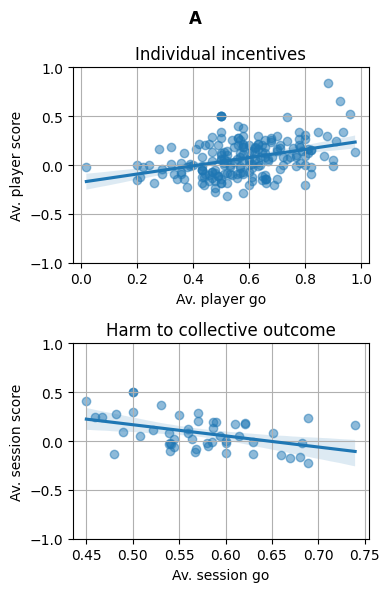

In [156]:
fig, ax = plt.subplots(2, 1, figsize=(4,6), tight_layout=True)

# Individual incentives
sns.regplot(
    x='decision', y='score',
    scatter_kws={'alpha': 0.5}, 
    data=player_av_scores, ax=ax[0]
)
ax[0].set_xlabel("Av. player go")
ax[0].set_ylabel("Av. player score")
ax[0].set_title("Individual incentives")
ax[0].grid()
ax[0].set_ylim([-1,1])

# Harm to collective outcome

sns.regplot(
    x='decision', y='score', 
    scatter_kws={'alpha': 0.5}, 
    data=group_av_scores, ax=ax[1]
)
ax[1].set_xlabel("Av. session go")
ax[1].set_ylabel("Av. session score")
ax[1].set_title("Harm to collective outcome")
ax[1].grid()
ax[1].set_ylim([-1,1])

# Convert figure to image array
fig.suptitle("A", fontweight="bold")
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panel_A = np.array(pil_image)

Pearson coefficients per player

In [157]:
r, p_value = pearsonr(player_av_scores['decision'], player_av_scores['score'])

print(f"Pearson correlation coefficient: {r:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"{r:.3f} (p={p_value:.3f})")

Pearson correlation coefficient: 0.3705
P-value: 7.7511e-08
0.370 (p=0.000)


Pearson coefficients per group

In [158]:
r, p_value = pearsonr(group_av_scores['decision'], group_av_scores['score'])

print(f"Pearson correlation coefficient: {r:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"{r:.3f} (p={p_value:.3f})")

Pearson correlation coefficient: -0.4331
P-value: 1.5028e-03
-0.433 (p=0.002)


### Panel B --- Score per round vs per session

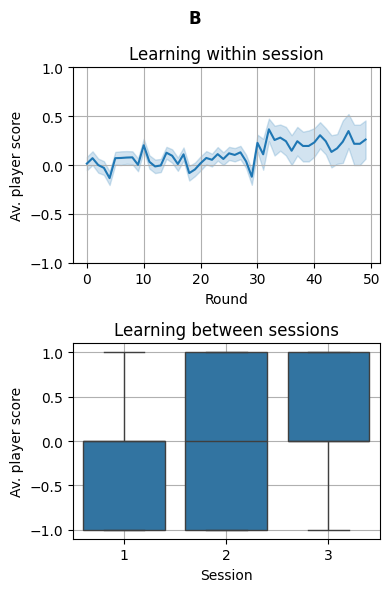

In [159]:
fig, ax = plt.subplots(
    2,1, 
    figsize=(4,6), 
    tight_layout=True,
    sharey=False
)

# Learning: average score increases per round
sns.lineplot(
    x='round', y='score', data=data,
    ci=95, ax=ax[0]
)
ax[0].set_xlabel('Round')
ax[0].set_ylabel("Av. player score")
ax[0].set_title("Learning within session")
ax[0].grid()
ax[0].set_ylim([-1,1])

# Learning: average score increases per session
sns.boxplot(
    x='session', y='score', 
    data=data, ax=ax[1],
)
ax[1].set_xlabel('Session')
ax[1].set_ylabel("Av. player score")
ax[1].set_title("Learning between sessions")
ax[1].grid()
# ax[1].set_ylim([-1,1])

# Convert figure to image array
fig.suptitle("B", fontweight="bold")
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panel_B = np.array(pil_image)

Pearson round vs score

In [160]:
pearson_coef, p_value = stats.pearsonr(data['score'], data['round'])

print(f"Pearson correlation coefficient: {pearson_coef}")
print(f"P-value: {p_value}")
print(f"{pearson_coef:.3f} (p={p_value:.3f})")

NameError: name 'stats' is not defined

Difference in means between session

In [161]:
# Get the unique session labels
sessions = data['session'].unique()

# Extract the scores for each session
scores_by_session = [data[data['session'] == session]['score'] for session in sessions]

# Perform the Kruskal-Wallis H-test
h_stat, p_value = stats.kruskal(*scores_by_session)

print(f"Kruskal-Wallis H statistic: {h_stat}")
print(f"P-value: {p_value}")
print(f"H={h_stat:.3f} (p={p_value:.3f})")

Kruskal-Wallis H statistic: 570.103029618226
P-value: 1.5984536963311556e-124
H=570.103 (p=0.000)


### Panels A and B 

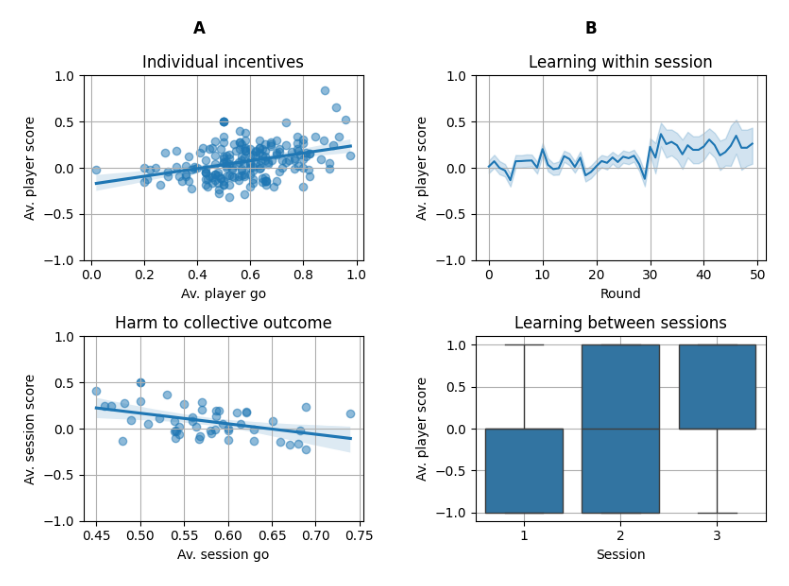

In [162]:
# fig = plt.figure(figsize=(12, 6), tight_layout=True)  # total width = 4 + 8 = 12, height = 6
# gs = gridspec.GridSpec(1, 12, figure=fig)  # 12 columns, 1 row

# ax1 = fig.add_subplot(gs[0, 0:4])
# ax1.imshow(panel_A)  

# ax2 = fig.add_subplot(gs[0, 4:12])
# ax2.imshow(panel_B)

# ax1.axis('off')
# ax2.axis('off')

fig, ax = plt.subplots(1, 2, figsize=(8,6), tight_layout=True)

ax[0].imshow(panel_A)  
ax[1].imshow(panel_B)

ax[0].axis('off')
ax[1].axis('off')

# Convert figure to image array
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panels_A_B = np.array(pil_image)

### Panel C --- Bounded efficiency vs. Bounded inequality

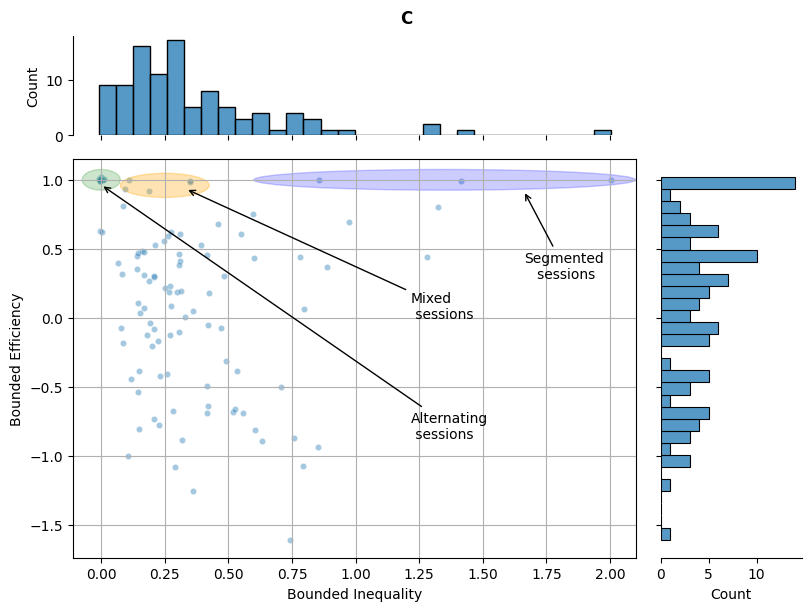

In [163]:
df_jitter = df.copy()
n = df_jitter.shape[0]
sigma = 0.0075
df_jitter['bounded_inequality'] = df_jitter['bounded_inequality'] + np.random.normal(0, sigma, n)
df_jitter['bounded_efficiency'] = df_jitter['bounded_efficiency'] + np.random.normal(0, sigma, n)

fig = plt.figure(figsize=(8,6), constrained_layout=True)

# One “slot” in a larger layout could be outer[0]; here we just show the joint block
gs_outer = fig.add_gridspec(1, 1)
gs = gs_outer[0].subgridspec(
    2, 2, height_ratios=[1, 4], width_ratios=[4, 1],
    hspace=0.05, wspace=0.05
)

ax_joint  = fig.add_subplot(gs[1, 0])
ax_marg_x = fig.add_subplot(gs[0, 0], sharex=ax_joint)
ax_marg_y = fig.add_subplot(gs[1, 1], sharey=ax_joint)

# Joint (scatter)
sns.scatterplot(
    x='bounded_inequality', y='bounded_efficiency',
    # style='predicted_class', hue='predicted_class',
    data=df_jitter,
    # hue='treatment', style='num_players',
    alpha=0.4, ax=ax_joint,
    palette='icefire',
    s=20
)
ax_joint.grid()

# Marginals (histograms)
sns.histplot(data=df_jitter, x='bounded_inequality', ax=ax_marg_x, bins=30)
sns.histplot(data=df_jitter, y='bounded_efficiency', ax=ax_marg_y, bins=30)

# Tidy up the marginal axes
ax_marg_x.tick_params(axis="x", labelbottom=False)
ax_marg_x.set_xlabel('')

ax_marg_y.tick_params(axis="y", labelleft=False)
ax_marg_y.set_ylabel('')

sns.despine(ax=ax_marg_x, bottom=True)
sns.despine(ax=ax_marg_y, left=True)

# Labels (now this is a normal Matplotlib figure you control)
ax_joint.set_xlabel("Bounded Inequality")
ax_joint.set_ylabel("Bounded Efficiency")

# Show the alternating groups on the top-left corner
circle = patches.Ellipse(
    (0, 1), width=0.15, height=0.15,
    # transform=ax_joint.transAxes, 
    color='green', alpha=0.2, 
)
ax_joint.add_patch(circle)
# Add an arrow pointing to the cluster
ax_joint.annotate(
    'Alternating\n sessions',
    xy=(0.05, 0.935), xycoords='axes fraction',
    xytext=(0.6, 0.3), textcoords='axes fraction',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10
)

# Show the mixed groups on the top center
circle = patches.Ellipse(
    (0.25, 0.96), width=0.35, height=0.175,
    # transform=ax.transAxes, 
    color='orange', alpha=0.3, 
)
ax_joint.add_patch(circle)
# Add an arrow pointing to the cluster
ax_joint.annotate(
    'Mixed\n sessions',
    xy=(0.2, 0.925), xycoords='axes fraction',
    xytext=(0.6, 0.6), textcoords='axes fraction',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10
)

# Show the segmented groups on the top-right corner
circle = patches.Ellipse(
    (1.35, 1), width=1.5, height=0.15, 
    # transform=ax.transAxes, 
    color='blue', alpha=0.2
)
ax_joint.add_patch(circle)
# Add an arrow pointing to the cluster
ax_joint.annotate(
    'Segmented\n   sessions',
    xy=(0.8, 0.92), xycoords='axes fraction',
    xytext=(0.8, 0.7), textcoords='axes fraction',
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10
)

# Convert figure to image array
fig.suptitle("C", fontweight="bold")
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panel_C = np.array(pil_image)

In [164]:
print(df['bounded_efficiency'].describe())

count    101.000000
mean       0.114013
std        0.635898
min       -1.604167
25%       -0.375000
50%        0.214286
75%        0.589286
max        1.000000
Name: bounded_efficiency, dtype: float64


In [165]:
df[df['bounded_efficiency'] > 0].size / df.size

0.6138613861386139

In [166]:
print(df['bounded_inequality'].describe())

count    101.000000
mean       0.362896
std        0.330662
min        0.000000
25%        0.157288
50%        0.276214
75%        0.471865
max        2.000000
Name: bounded_inequality, dtype: float64


### Panels A, B and C

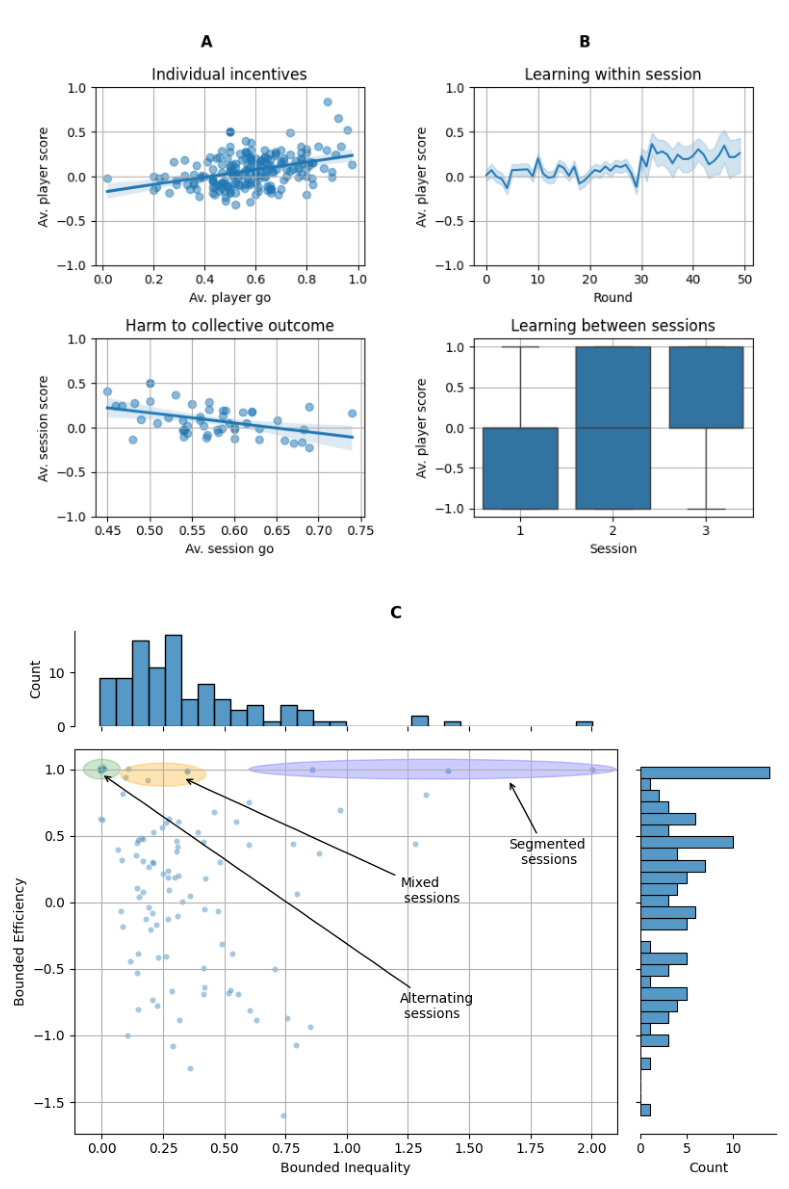

In [167]:
# fig = plt.figure(figsize=(8, 12), tight_layout=True)  # total width = 4 + 8 = 12, height = 6
# gs = gridspec.GridSpec(1, 12, figure=fig)  # 12 columns, 1 row

# ax1 = fig.add_subplot(gs[0, 0:4])
# ax1.imshow(panels_A_B)  

# ax2 = fig.add_subplot(gs[0, 4:12])
# ax2.imshow(panel_C)

# ax1.axis('off')
# ax2.axis('off')

fig, ax = plt.subplots(2, 1, figsize=(8,12), tight_layout=True)

ax[0].imshow(panels_A_B)  
ax[1].imshow(panel_C)

ax[0].axis('off')
ax[1].axis('off')

# Convert figure to image array
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panels_A_B_C = np.array(pil_image)

### Panel D --- Influence of threshold and number of players

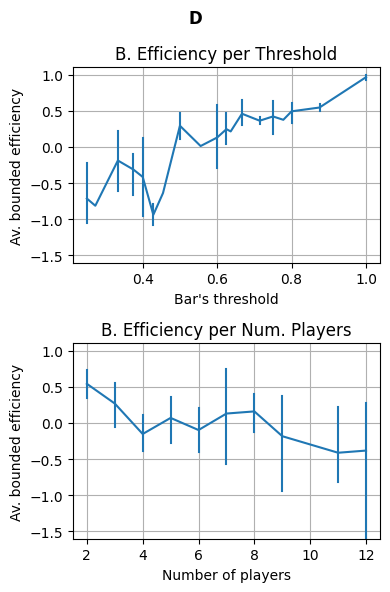

In [168]:
fig, ax = plt.subplots(
    2, 1, 
    figsize=(4,6), 
    tight_layout=True,
    # sharex=True, sharey=True
)

# Efficiency per threshold and treatment
sns.lineplot(
    x='threshold', y='bounded_efficiency',
    data=df, ax=ax[0],
    err_style="bars",
    errorbar="ci",
    palette='icefire'
)
ax[0].set_xlabel("Bar's threshold")
ax[0].set_ylabel("Av. bounded efficiency")
ax[0].set_title("B. Efficiency per Threshold")
ax[0].grid()
ax[0].set_ylim([-1.6,1.1])

# Efficiency per number of agents and treatment
sns.lineplot(
    x='num_players', y='bounded_efficiency',
    data=df, ax=ax[1],
    err_style="bars",
    errorbar="ci",
    palette='icefire'
)
ax[1].set_xlabel("Number of players")
ax[1].set_ylabel("Av. bounded efficiency")
ax[1].set_title("B. Efficiency per Num. Players")
ax[1].grid()
ax[1].set_ylim([-1.6,1.1])


# Convert figure to image array
fig.suptitle("D", fontweight="bold")
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panel_D = np.array(pil_image)

### Panel E --- Effects of treatments

In [169]:
data_2P = data[data['num_players'] == 2]
data_2P['treatment'] = data_2P['treatment'].apply(
    lambda x: 'partial information' if x == 'only score'
                else 'full information'
)
TwoP_group_av_scores = group_av_scores = data_2P.groupby(['treatment', 'group']).agg({
    'score':'mean',
    'decision':'mean'
})


def get_threshold_level(x:float) -> str:
    q = math.floor(x * 4 + 0.5) / 4.0   # redondeo a múltiplos de 0.25, half-up
    level = max(0.25, q)
    if level < 0.5:
        return 'low'
    elif level == 0.5:
        return 'middle'
    else:
        return 'high'

data_MP = data[data['num_players'] > 2]
data_MP['thresh_level'] = data_MP['threshold'].apply(get_threshold_level)
MP_group_av_scores = group_av_scores = data_MP.groupby(['treatment', 'group', 'threshold', 'thresh_level']).agg({
    'score':'mean',
    'decision':'mean'
}).reset_index()
MP_group_av_scores['bounded_efficiency'] = MP_group_av_scores['score'] / MP_group_av_scores['threshold']

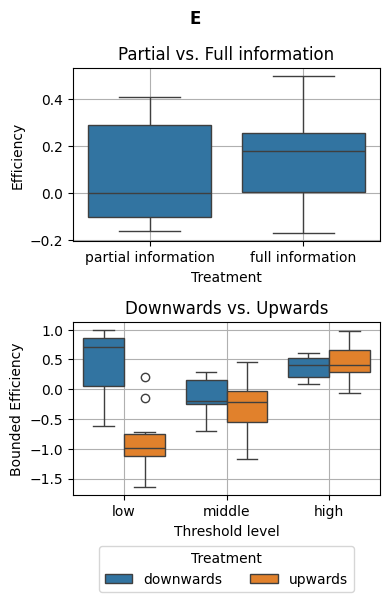

In [170]:
fig, ax = plt.subplots(2, 1, figsize=(4,6), tight_layout=True)

# Distribution of efficiency vs treatment in Two-player experiment
sns.boxplot(
    x='treatment', y='score',
    data=TwoP_group_av_scores, ax=ax[0], 
    order=['partial information', 'full information'],
    hue_order=['partial information', 'full information'],
)
# sns.swarmplot(
#     x='treatment', y='score', color='black',
#     data=TwoP_group_av_scores, ax=ax[0], order=['only score', 'score + grid'],
#     hue_order=['only score', 'score + grid'],
# )
ax[0].set_xlabel('Treatment')
ax[0].set_ylabel('Efficiency')
ax[0].set_title('Partial vs. Full information')
ax[0].legend().remove()
ax[0].grid()

# Distribution of efficiency vs treatment in Multi-player experiment
sns.boxplot(
    x='thresh_level', y='bounded_efficiency', hue='treatment',
    data=MP_group_av_scores, ax=ax[1], 
    order=['low', 'middle', 'high'],
    hue_order=['downwards', 'upwards'],
)
# sns.swarmplot(
#     x='thresh_level', y='score', hue='treatment', color='black',   
#     data=MP_group_av_scores, ax=ax[1],
# )
ax[1].set_xlabel('Threshold level')
ax[1].set_ylabel('Bounded Efficiency')
ax[1].set_title('Downwards vs. Upwards')
ax[1].legend(
    title='Treatment',
    loc='lower center', 
    bbox_to_anchor=(0.5, -0.6),
    ncol=2
)
ax[1].grid()

# Convert figure to image array
fig.suptitle("E", fontweight="bold")
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panel_E = np.array(pil_image)

### Panels D and E

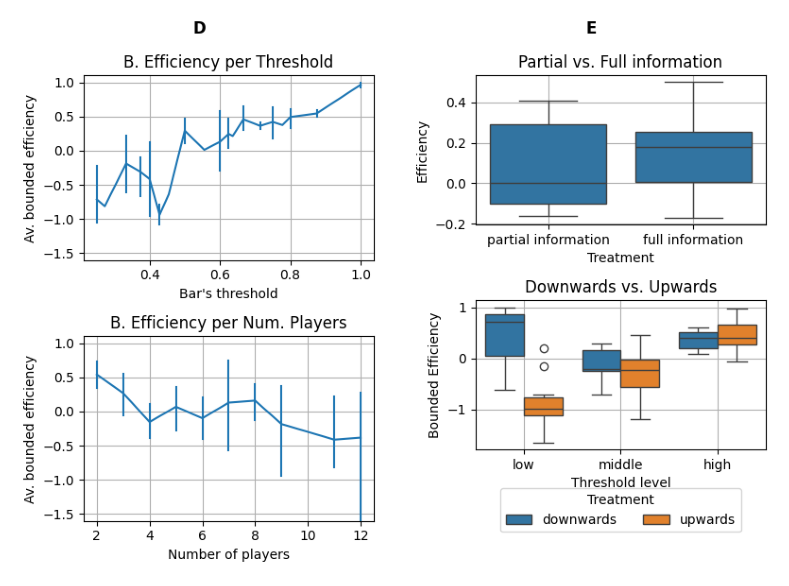

In [171]:
# fig, ax = plt.subplots(1, 3, figsize=(12,6), tight_layout=True)

# ax[0].imshow(panel_C)  
# ax[1].imshow(panel_D)
# ax[2].imshow(panel_E)

# ax[0].axis('off')
# ax[1].axis('off')
# ax[2].axis('off')

fig, ax = plt.subplots(1, 2, figsize=(8,6), tight_layout=True)

ax[0].imshow(panel_D)  
ax[1].imshow(panel_E)

ax[0].axis('off')
ax[1].axis('off')

# Convert figure to image array
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panels_D_E = np.array(pil_image)

Panels A to E

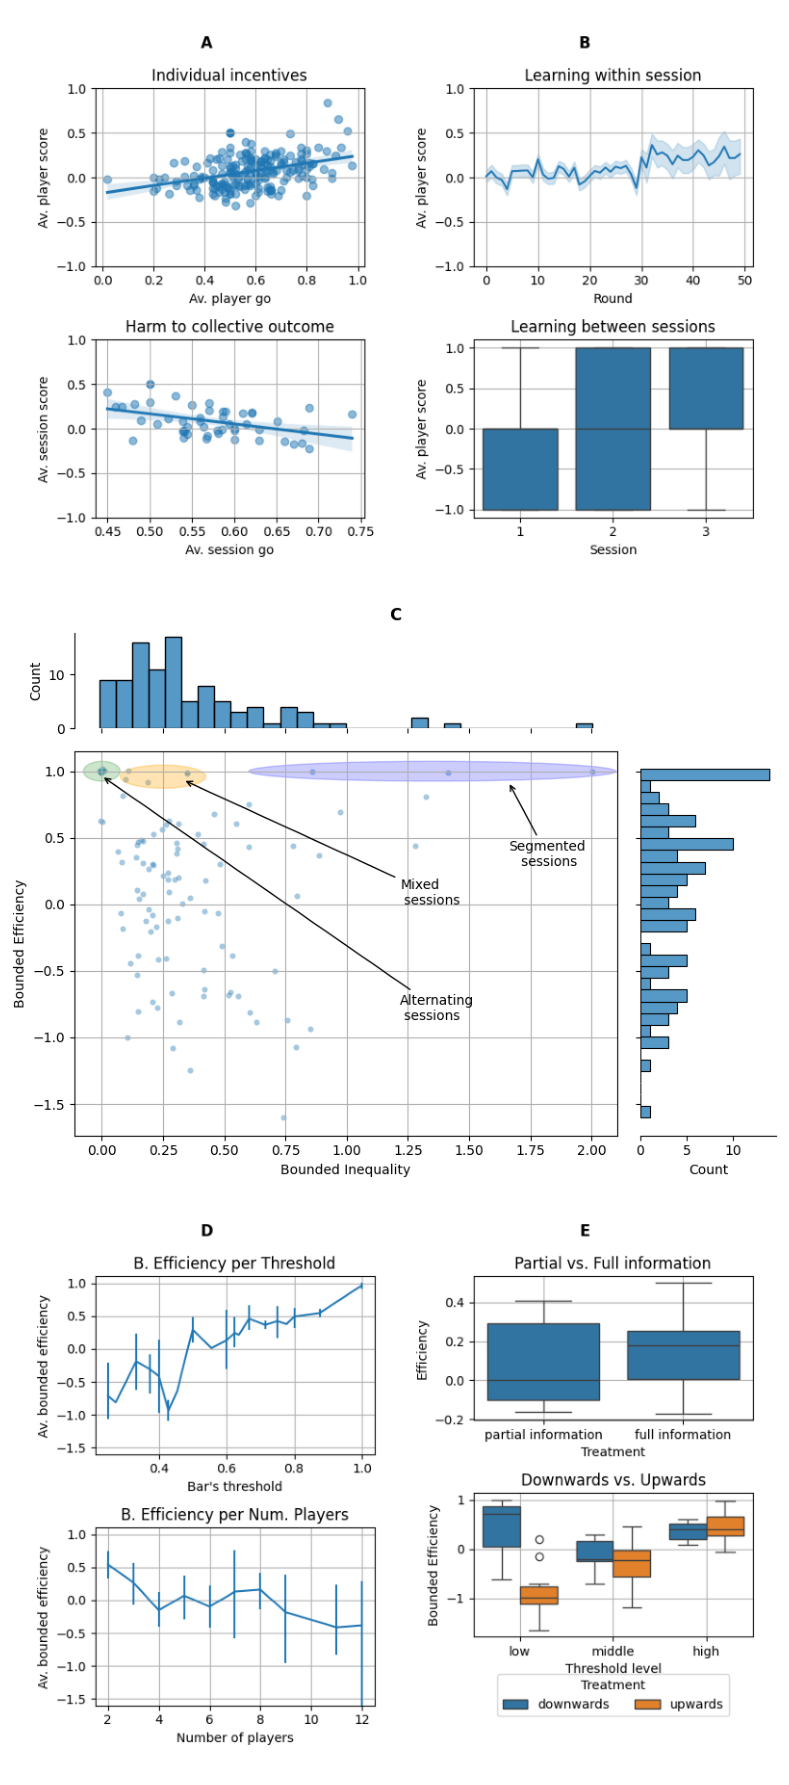

In [172]:
fig, ax = plt.subplots(3, 1, figsize=(8,18), tight_layout=True)

ax[0].imshow(panels_A_B)  
ax[1].imshow(panel_C)  
ax[2].imshow(panels_D_E)

ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')

# Convert figure to image array
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panels_A_B_C_D_E = np.array(pil_image)

### Panel F --- Examples of playouts

In [173]:
# Load human data
file_name = 'all_data.csv'
file = PATHS['human_data'] / Path(file_name)
print(f'Loading data from {file}...')
data = pd.read_csv(file)
data['source'] = 'humans'
data['model'] = data.apply(lambda row: f"{row['room']}-{row['num_players']}-{row['threshold']:.2f}", axis=1)
data['num_players'] = data['num_players'].astype(int)
data['round'] = data['round'].astype(int)
data['decision'] = data['decision'].astype(int)
data['group'] = data['group'].apply(lambda x: x.split('-')[0] if 'Grupo' not in x else x.split('-')[1])

# data = data[data['threshold'] != 1]
data.drop(columns=['room', 'date', 'timeup', 'time', 'attendance', 'ac_score', 'choice'], inplace=True)

Loading data from /Users/edgar/Documents/GitHub/Cognitive_Models_El_Farol_Bar_Problem/data/human/all_data.csv...


In [174]:
# Change round to round within session
dict_num_sessions = {}
for key, grp in data.groupby('group'):
    num_players = grp['num_players'].unique()[0]
    num_sessions = grp['threshold'].unique().size
    x = dict_num_sessions.get(num_players, None)
    if x != None and num_sessions != x:
        raise Exception('Inconsistent number of sessions per number of players')
    dict_num_sessions[num_players] = num_sessions
    
group_counter = {grp:0 for grp in data['group'].unique()}
rounds_counter = dict() 
dict_sessions_downwards = defaultdict()
dict_sessions_upwards = defaultdict()
data.sort_values(by=['group', 'treatment', 'threshold'], inplace=True)
for (group, treatment, threshold, num_players), grp in data.groupby(['group', 'treatment', 'threshold', 'num_players']):
    rounds_counter[(group, threshold)] = [grp['round'].min(), grp['round'].max()]
    num_thresholds = dict_num_sessions[num_players]
    if treatment == 'downwards':
        count = num_thresholds - group_counter[group]
        group_counter[group] += 1
        dict_sessions_downwards[(group, threshold)] = count
    elif treatment == 'upwards':
        group_counter[group] += 1
        count = group_counter[group]
        dict_sessions_upwards[(group, threshold)] = count
    else:
        dict_sessions_downwards[(group, threshold)] = 1

dict_sessions = dict_sessions_downwards.copy()
dict_sessions.update(dict_sessions_upwards)

def get_round(row):
    x = int(row['round'])
    m, M = rounds_counter[(row['group'], row['threshold'])]
    return (x - m) % M

data['round'] = data.apply(lambda row: get_round(row), axis=1).astype(int)
data['session'] = data.apply(lambda row: dict_sessions[(row['group'], row['threshold'])], axis=1)
# data['group'] = data.apply(lambda row: f"{row['group']}-{row['session']}", axis=1)
# data = data[data['round'] <= 30]

data.sort_values(by=['num_players', 'threshold'], inplace=True)

print('Group sizes:', ', '.join([str(x) for x in data['num_players'].unique()]))
print('Number of groups:', len(data['group'].unique()))

Group sizes: 2, 3, 4, 5, 6, 7, 8, 9, 11, 12
Number of groups: 51


In [175]:
# Calculate alternation index per group
gm = GetMeasurements(
    data=data,
    measures=['efficiency', 'bounded_efficiency', 'entropy', 'conditional_entropy', 'inequality', 'bounded_inequality'],
    T=25
)
df = gm.get_measurements()

# Find coordination type
alt_index = AlternationIndex.from_file(priority='mlp')
df['predicted_class'] = alt_index.classify(df)

In [176]:
df_best = df[df['bounded_efficiency'] > 0.5]
df_best = df_best[df_best['threshold'] < 1]

# df_best['model'] = df_best.apply(lambda row: f"{row['model']}-{row['num_players']}-{row['threshold']:.2f}", axis=1)
df_best.sort_values(by=['bounded_efficiency', 'num_players'], ascending=False, inplace=True)
print('Num. of best sessions:', len(df_best))
# df_best

Num. of best sessions: 27


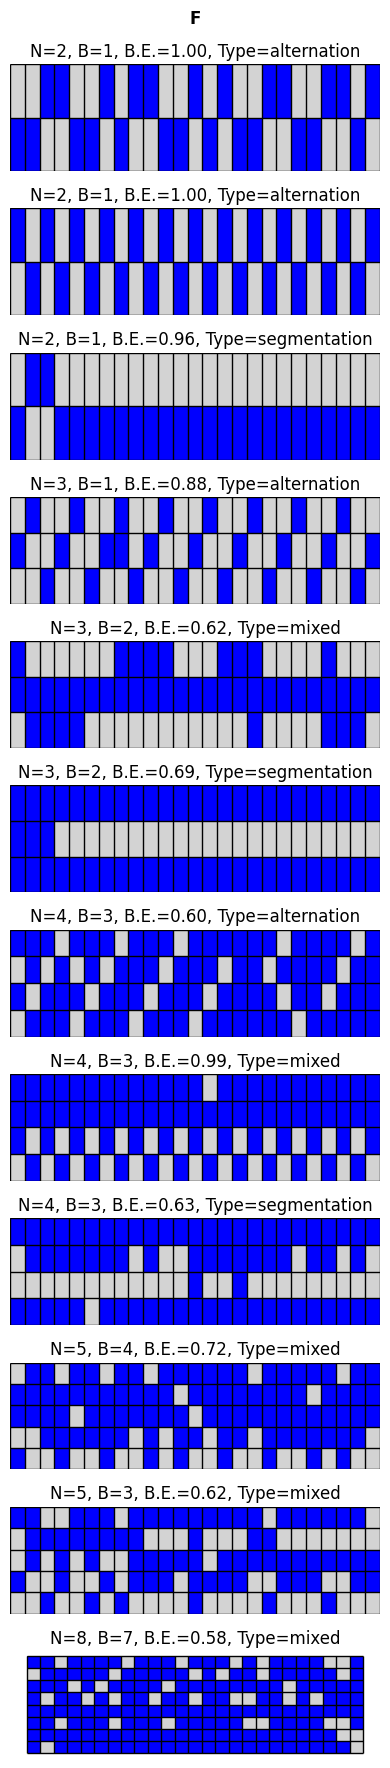

In [177]:
# groups = df_best['model'].unique()
keep_groups_idx = [
    4, 3, 7, 8, 20, 16, 21, 5, 18, 14, 19, 22
]
groups = np.array(df_best['model'].unique())[keep_groups_idx].tolist()
categories = [
    'alternation', 'alternation', 'segmentation',
    'alternation', 'mixed', 'segmentation',
    'alternation', 'mixed', 'segmentation',
    'mixed', 'mixed', 'mixed'
]

fig, axes = plt.subplots(
    12, 1, 
    figsize=(4, 18),
    tight_layout=True
)

for i, group in enumerate(groups):
    df_aux = df_best[df_best['model'] == group]
    df_aux_aux = data[data['model'] == group]
    threshold = df_aux['threshold'].unique()[0]
    BE = df_aux['bounded_efficiency'].unique()[0]
    N = df_aux_aux['num_players'].values[0]
    B = int(df_aux_aux['threshold'].values[0] * N)
    # classification = df_aux['predicted_class'].values[0]
    classification = categories[i]
    # classification = i
    bar_renderer = BarRenderer(data=df_aux_aux)
    bar_renderer.render(
        ax=axes[i],
        title=f"N={N}, B={B}, B.E.={BE:.2f}, Type={classification}",
        num_rounds=25
    )

# Convert figure to image array
fig.suptitle("F\n", fontweight="bold")
fig.canvas.draw()
rgba_bytes = fig.canvas.buffer_rgba().tobytes()
width, height = fig.canvas.get_width_height()
pil_image = PIL.Image.frombytes(mode="RGBA", size=[width, height], data=rgba_bytes)
panel_F = np.array(pil_image)

### All panels

(np.float64(-0.5), np.float64(399.5), np.float64(1799.5), np.float64(-0.5))

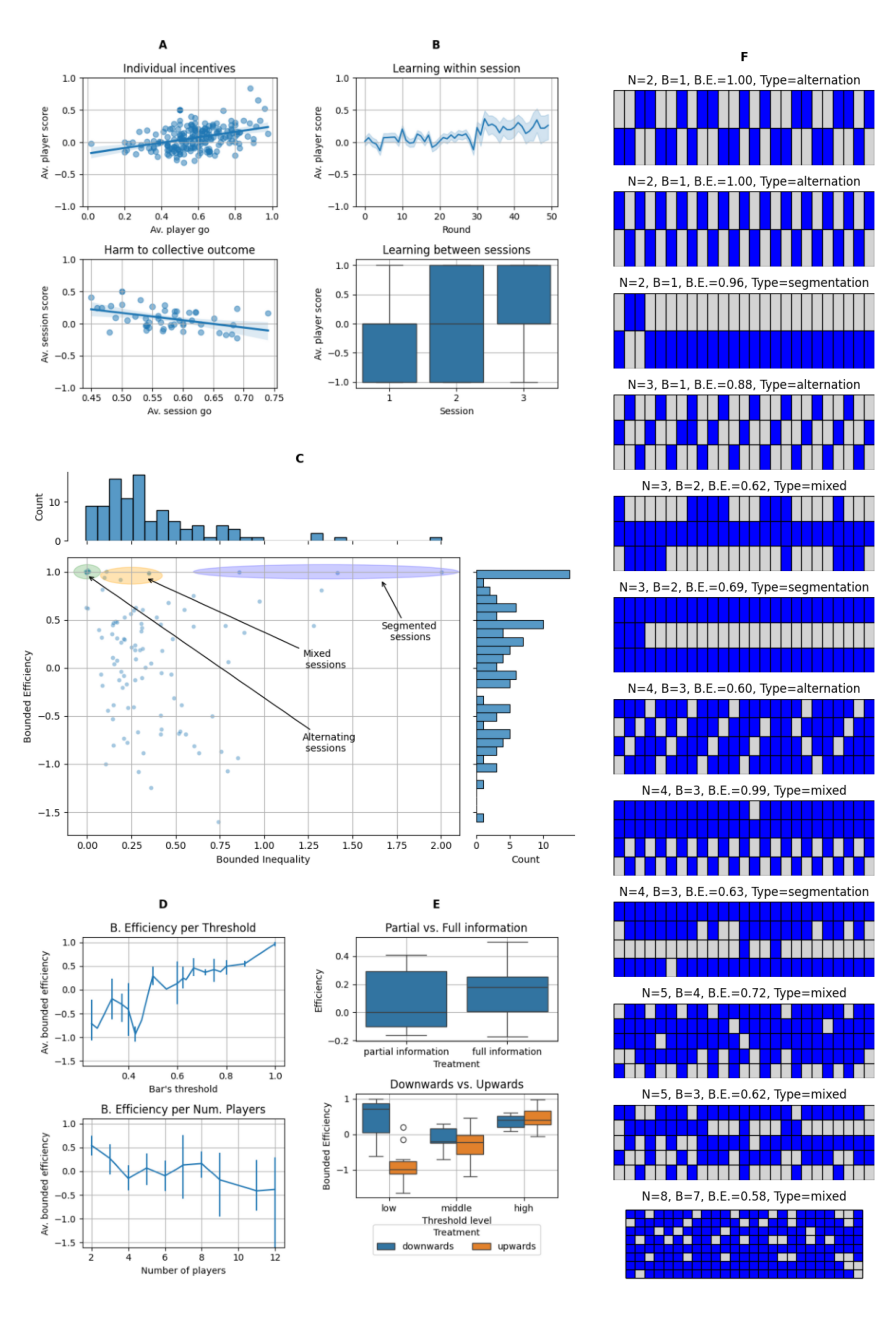

In [178]:
fig = plt.figure(figsize=(12, 18), tight_layout=True)  
gs = gridspec.GridSpec(1, 16, figure=fig)  

ax1 = fig.add_subplot(gs[0, 0:8])
ax1.imshow(panels_A_B_C_D_E)  

ax2 = fig.add_subplot(gs[0, 8:12])
ax2.imshow(panel_F)

ax1.axis('off')
ax2.axis('off')

In [179]:
fig.savefig(PATHS['figures_for_paper'] / 'Short_Fig2.png', dpi=300, bbox_inches='tight')

---

### Regressions

In [180]:
formula = 'score ~ treatment + num_players + threshold + round + session ' 
formula += '+ num_players * threshold + round * session + treatment * threshold + treatment * num_players'
lm = ols(formula, data).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     210.0
Date:                Wed, 17 Sep 2025   Prob (F-statistic):               0.00
Time:                        13:25:38   Log-Likelihood:                -17183.
No. Observations:               15980   AIC:                         3.439e+04
Df Residuals:                   15968   BIC:                         3.448e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [181]:
# Calculate alternation index per group
gm = GetMeasurements(
    data=data,
    measures=['efficiency', 'bounded_efficiency', 'entropy', 'conditional_entropy', 'inequality'],
)
df = gm.get_measurements()

alt_index = AlternationIndex.from_file(priority='sklearn')
df['alternation_index'] = alt_index(df)

df.head(2)

,model,treatment,threshold,num_players,group,efficiency,bounded_efficiency,entropy,conditional_entropy,inequality,alternation_index
0,11-8-0.38,downwards,0.375,8,11,-0.073276,-0.195402,0.590006,0.017857,0.101689,0.000750
1,11-8-0.62,downwards,0.625,8,11,0.072581,0.116129,0.540606,0.072957,0.129893,0.000219


In [182]:
formula = 'bounded_efficiency ~ num_players + threshold + num_players * threshold'
lm = ols(formula, df).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:     bounded_efficiency   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     40.61
Date:                Wed, 17 Sep 2025   Prob (F-statistic):           4.35e-17
Time:                        13:25:43   Log-Likelihood:                -51.853
No. Observations:                 101   AIC:                             111.7
Df Residuals:                      97   BIC:                             122.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.75

In [183]:
formula = 'bounded_efficiency ~ treatment + num_players + threshold'
formula += '+ num_players * threshold + treatment * threshold + treatment * num_players'
lm = ols(formula, df[df['num_players'] > 2]).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:     bounded_efficiency   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     35.07
Date:                Wed, 17 Sep 2025   Prob (F-statistic):           2.28e-19
Time:                        13:25:43   Log-Likelihood:                -21.770
No. Observations:                  78   AIC:                             57.54
Df Residuals:                      71   BIC:                             74.04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

In [184]:
formula = 'alternation_index ~ treatment + num_players + threshold'
formula += '+ num_players * threshold + treatment * threshold + treatment * num_players'
lm = ols(formula, df).fit()

print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:      alternation_index   R-squared:                       0.342
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     5.967
Date:                Wed, 17 Sep 2025   Prob (F-statistic):           3.72e-06
Time:                        13:25:43   Log-Likelihood:                 19.349
No. Observations:                 101   AIC:                            -20.70
Df Residuals:                      92   BIC:                             2.838
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

### Check collective action dilemma

In [185]:
player_av_scores = data.groupby(['player']).agg({
    'score':'mean',
    'decision':'mean'
})

group_av_scores = data.groupby(['group']).agg({
    'score':'mean',
    'decision':'mean'
})

In [186]:
from scipy.stats import pearsonr

In [187]:
r, p_value = pearsonr(player_av_scores['decision'], player_av_scores['score'])

print(f"Pearson correlation coefficient: {r:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"{r:.3f} (p={p_value:.3f})")

Pearson correlation coefficient: 0.3705
P-value: 7.7511e-08
0.370 (p=0.000)


In [188]:
r, p_value = pearsonr(group_av_scores['decision'], group_av_scores['score'])

print(f"Pearson correlation coefficient: {r:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"{r:.3f} (p={p_value:.3f})")

Pearson correlation coefficient: -0.4331
P-value: 1.5028e-03
-0.433 (p=0.002)


---